In [ ]:
!pip install imbalanced-learn scikit-learn
!pip install statsmodels


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
# importing libraries here to better keep track of them

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Reading csv files into memory

injury_history_raw = pd.read_csv("data/injury_history(injury_history).csv", sep = ",", encoding = 'ISO-8859-1')
muscle_imbalance_raw = pd.read_csv("data/injury_history(muscle_imbalance_data).csv", sep = ",", encoding = 'ISO-8859-1')
player_sessions_raw = pd.read_csv("data/injury_history(player_sessions).csv", sep = ",", encoding = 'ISO-8859-1')

In [3]:
injury_history_raw['Injury Date'] = pd.to_datetime(injury_history_raw['Injury Date'], errors = 'coerce')
injury_history_raw['Month'] = injury_history_raw['Injury Date'].dt.month
injury_history_raw['Year'] = injury_history_raw['Injury Date'].dt.year

player_sessions_raw['Month'] = pd.to_datetime(player_sessions_raw['Session_Date']).dt.month
player_sessions_raw['Year'] = pd.to_datetime(player_sessions_raw['Session_Date']).dt.year

muscle_imbalance_raw['Month'] = pd.to_datetime(muscle_imbalance_raw['Date Recorded']).dt.month
muscle_imbalance_raw['Year'] = pd.to_datetime(muscle_imbalance_raw['Date Recorded']).dt.year

In [4]:
injury_history_raw[['Player.ID', 'Name', 'Injury Date', 'Month','Year']].value_counts()

Player.ID  Name              Injury Date  Month  Year
101        Jordan Matthews   2023-07-22   7      2023    1
                             2023-10-25   10     2023    1
                             2023-12-05   12     2023    1
103        Malik Robinson    2023-02-14   2      2023    1
                             2023-06-28   6      2023    1
                             2023-09-27   9      2023    1
105        Noah Bradley      2023-01-13   1      2023    1
                             2023-09-20   9      2023    1
                             2023-12-19   12     2023    1
106        Lennon Van        2024-01-01   1      2024    1
107        Cameron Howard    2023-12-21   12     2023    1
109        Miles Richardson  2023-07-05   7      2023    1
110        Kyle Saunders     2023-10-09   10     2023    1
112        Anthony Lopez     2023-01-26   1      2023    1
                             2023-07-15   7      2023    1
                             2023-11-18   11     2023    1
11

In [5]:
injury_history_raw.sort_values(['Player.ID', 'Injury Date', 'Month', 'Year'], inplace = True)
injury_history_raw['injury_number'] = injury_history_raw.groupby(['Player.ID', 'Body Part']).cumcount() + 1
injury_history_raw[['Player.ID', 'Name', 'Injury Date', 'Month','Year', 'Body Part', 'injury_number']].value_counts()

Player.ID  Name              Injury Date  Month  Year  Body Part   injury_number
101        Jordan Matthews   2023-07-22   7      2023  Shoulder    1                1
                             2023-10-25   10     2023  Wrist       1                1
                             2023-12-05   12     2023  Quadriceps  1                1
103        Malik Robinson    2023-02-14   2      2023  Wrist       1                1
                             2023-06-28   6      2023  Groin       1                1
                             2023-09-27   9      2023  Head        1                1
105        Noah Bradley      2023-01-13   1      2023  Lower Back  1                1
                             2023-09-20   9      2023  Lower Back  2                1
                             2023-12-19   12     2023  Head        1                1
106        Lennon Van        2024-01-01   1      2024  Knee        1                1
107        Cameron Howard    2023-12-21   12     2023  Knee

In [6]:
print(f"Raw Injury Data: \n {injury_history_raw.head()} \n")
print(f"Raw Muscle Imbalance Data: \n {muscle_imbalance_raw.head()} \n")
print(f"Raw Player Session Data: \n {player_sessions_raw.head()} \n")

Raw Injury Data: 
    Player.ID             Name  Group.Id    Injury Type   Body Part   Side  \
2        101  Jordan Matthews       201     Tendonitis    Shoulder  Right   
1        101  Jordan Matthews       201     Tendonitis       Wrist   Left   
0        101  Jordan Matthews       201  Muscle Strain  Quadriceps  Right   
4        103   Malik Robinson       203       Fracture       Wrist   Left   
3        103   Malik Robinson       203         Strain       Groin  Right   

  Injury Date Severity  Recovery Time (days)  \
2  2023-07-22      NaN                    12   
1  2023-10-25      NaN                    11   
0  2023-12-05  Grade 2                    51   
4  2023-02-14      NaN                    68   
3  2023-06-28  Grade 1                    20   

                                    Additional Notes  Month  Year  \
2  Rotator cuff tendonitis due to overuse. Anti-i...      7  2023   
1  De Quervain's tenosynovitis. Swelling and pain...     10  2023   
0  Grade 2 quadriceps 

In [7]:
print(f'Columns present in injury data: \n {injury_history_raw.columns} \n')
print(f'Columns present in muscle imbalance data: \n {muscle_imbalance_raw.columns} \n')
print(f'Columns present in player session data: \n {player_sessions_raw.columns} \n')

Columns present in injury data: 
 Index(['Player.ID', 'Name', 'Group.Id', 'Injury Type', 'Body Part', 'Side',
       'Injury Date', 'Severity', 'Recovery Time (days)', 'Additional Notes',
       'Month', 'Year', 'injury_number'],
      dtype='object') 

Columns present in muscle imbalance data: 
 Index(['Player.ID', 'Session ID', 'Player Name', 'Date Recorded',
       'Hamstring To Quad Ratio', 'Quad Imbalance Percent',
       'HamstringImbalance Percent', 'Calf Imbalance Percent',
       'Groin Imbalance Percent', 'Month', 'Year'],
      dtype='object') 

Columns present in player session data: 
 Index(['Name', 'Player.ID', 'Group.Id', 'Group.name', 'League.ID',
       'Session.ID', 'Session_Date', 'Position', 'Distance..mi.',
       'Distance...min..mi.', 'Duration..s.', 'Steps', 'Speed....of.max......',
       'Speed..max....mph.', 'Speed..?ò...mph.', 'Time..s.',
       'Accumulated.Acceleration.Load', 'Anaerobic.Activity..distance...mi.',
       'Jump.Load..J.', 'Heart.Rate..?ò...b

## Player Session Data column research

#### TRIMP - A way to measure Training Impulse (Aerobic Training Load). It is a product of Training volume (minutes) and Training intensity (beats per minutes). 

TRIMP = Training VOlume * Training Intensity. For example if a workout is 50 minutes and the average heart rate (bpm) is 140 bpm, TRIMP score is calculated out to 7000. TRIMP is affected by a number of factors but we can look for correlation on a correlation matrix as well. 
    - Physical Settings
    - Resting and Maximal Heart Rate
    - Gender (since its mbb there's not going to be any variance with this feature)

TRIMP can be used to compare sessions of different lengths, or to compare high-intensity sessions with longer game data. For example if a session with TRIMP score of 108 might be considered moderate, the TRIMP/min score could indicate an intense session if Training Volume is lower. Training Stress Score (TSS) is a proprietary variant based on a score of 100 for a 1-hour maximum sustained effort. 
Positive correlation between Heart Rate and Effort

---

In [8]:
print(f'Size of injury history data: \n {injury_history_raw.shape}\n')
print(f'Size of muscle imbalance data: \n {muscle_imbalance_raw.shape}\n')
print(f'Size of player session data: \n {player_sessions_raw.shape}\n')

Size of injury history data: 
 (21, 13)

Size of muscle imbalance data: 
 (182, 11)

Size of player session data: 
 (2604, 32)



## Null Values

In [9]:
print(f'Null Values in injury history data: \n {injury_history_raw.isnull().sum()}')
print(f'Null Values in muscle imbalance data: \n {muscle_imbalance_raw.isnull().sum()}')
print(f'Null Values in player session data: \n {player_sessions_raw.isnull().sum()}')

Null Values in injury history data: 
 Player.ID                0
Name                     0
Group.Id                 0
Injury Type              0
Body Part                0
Side                     5
Injury Date              0
Severity                10
Recovery Time (days)     0
Additional Notes         0
Month                    0
Year                     0
injury_number            0
dtype: int64
Null Values in muscle imbalance data: 
 Player.ID                     0
Session ID                    0
Player Name                   0
Date Recorded                 0
Hamstring To Quad Ratio       0
Quad Imbalance Percent        0
HamstringImbalance Percent    0
Calf Imbalance Percent        0
Groin Imbalance Percent       0
Month                         0
Year                          0
dtype: int64
Null Values in player session data: 
 Name                                  0
Player.ID                             0
Group.Id                              0
Group.name                         

Okay so with null values, injury history data is the only dataset with null values. There are 2 columns with null values with a total of 15 null values. Less than 10% of the data. We should delete the data since we are working with health data instead of imputing the values. I think it will introduce bias through assumption. Our train test split is going to be pretty weak since we only will have 167 instances. 

In [10]:
injury_history_raw.sort_index(inplace = True)

In [11]:
twothird_data = pd.merge(muscle_imbalance_raw, player_sessions_raw, on = ['Player.ID', 'Month', 'Year'], how = 'right')
twothird_data.head()

,Player.ID,Session ID,Player Name,Date Recorded,Hamstring To Quad Ratio,Quad Imbalance Percent,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Month,...,Heart.Rate..min....bpm.,Heart.Rate..max....bpm.,Human.Core.Temperature..?ò....F.,Human.Core.Temperature..max.....F.,TRIMP,Heart.Rate.Recoveries,Jump.Height..max....ft.,Changes.of.Orientation,Exertions,Disk.Usage....
0,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,74,198,99.47,101.24,261,5,2.31,229,307,58.56
1,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,62,179,99.56,99.33,270,6,2.44,427,180,44.93
2,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,78,172,100.06,102.31,149,4,3.04,383,440,15.32
3,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,64,186,100.45,101.10,180,10,3.17,462,450,21.46
4,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,62,146,98.73,100.91,152,4,1.28,118,416,20.51


In [12]:
obt = pd.merge(twothird_data, injury_history_raw, on = ['Player.ID', 'Month', 'Year'], how = 'left')
obt.tail()

,Player.ID,Session ID,Player Name,Date Recorded,Hamstring To Quad Ratio,Quad Imbalance Percent,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Month,...,Name_y,Group.Id_y,Injury Type,Body Part,Side,Injury Date,Severity,Recovery Time (days),Additional Notes,injury_number
2599,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2600,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2601,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2602,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2603,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [13]:
obt.isnull().sum()

Player.ID                                0
Session ID                               0
Player Name                              0
Date Recorded                            0
Hamstring To Quad Ratio                  0
Quad Imbalance Percent                   0
HamstringImbalance Percent               0
Calf Imbalance Percent                   0
Groin Imbalance Percent                  0
Month                                    0
Year                                     0
Name_x                                   0
Group.Id_x                               0
Group.name                               0
League.ID                                0
Session.ID                               0
Session_Date                             0
Position                                 0
Distance..mi.                            0
Distance...min..mi.                      0
Duration..s.                             0
Steps                                    0
Speed....of.max......                    0
Speed..max.

In [14]:
obt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2604 entries, 0 to 2603
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Player.ID                           2604 non-null   int64         
 1   Session ID                          2604 non-null   int64         
 2   Player Name                         2604 non-null   object        
 3   Date Recorded                       2604 non-null   object        
 4   Hamstring To Quad Ratio             2604 non-null   float64       
 5   Quad Imbalance Percent              2604 non-null   float64       
 6   HamstringImbalance Percent          2604 non-null   float64       
 7   Calf Imbalance Percent              2604 non-null   float64       
 8   Groin Imbalance Percent             2604 non-null   float64       
 9   Month                               2604 non-null   int32         
 10  Year                    

In [15]:
# Dropping columns that are repeated and redundant (no variance among values in column). 
distinct_obt = obt.drop(columns = ['Group.name', 'League.ID', 'Name_y', 'Group.Id_y', 'Name_x', 'Severity', 'Side'])
# Dropping Severity and side since removing null values will result in removing certain injuries.

In [16]:
distinct_obt.isna().sum()

Player.ID                                0
Session ID                               0
Player Name                              0
Date Recorded                            0
Hamstring To Quad Ratio                  0
Quad Imbalance Percent                   0
HamstringImbalance Percent               0
Calf Imbalance Percent                   0
Groin Imbalance Percent                  0
Month                                    0
Year                                     0
Group.Id_x                               0
Session.ID                               0
Session_Date                             0
Position                                 0
Distance..mi.                            0
Distance...min..mi.                      0
Duration..s.                             0
Steps                                    0
Speed....of.max......                    0
Speed..max....mph.                       0
Speed..?ò...mph.                         0
Time..s.                                 0
Accumulated

In [17]:
distinct_obt.tail()

,Player.ID,Session ID,Player Name,Date Recorded,Hamstring To Quad Ratio,Quad Imbalance Percent,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Month,...,Jump.Height..max....ft.,Changes.of.Orientation,Exertions,Disk.Usage....,Injury Type,Body Part,Injury Date,Recovery Time (days),Additional Notes,injury_number
2599,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,2.49,179,336,2.65,NaN,NaN,NaT,NaN,NaN,NaN
2600,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,1.44,386,341,87.83,NaN,NaN,NaT,NaN,NaN,NaN
2601,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,3.68,169,153,36.56,NaN,NaN,NaT,NaN,NaN,NaN
2602,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,3.12,416,236,53.61,NaN,NaN,NaT,NaN,NaN,NaN
2603,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,2.53,372,392,16.67,NaN,NaN,NaT,NaN,NaN,NaN


In [18]:
# Injury type, Body Part, Injury Date, Recovery Time, and Additional Notes all have the same number of null values indicating that these players may not have injuries. 
distinct_obt['Injury Type'].fillna("Not Injured", inplace=True)
distinct_obt['Body Part'].fillna("None", inplace = True)
distinct_obt['Injury Date'].fillna("12/31/2026", inplace = True)
distinct_obt['Recovery Time (days)'].fillna(0, inplace = True) 
distinct_obt['Additional Notes'].fillna("Not Injured", inplace = True)
distinct_obt['injury_number'].fillna(0, inplace = True)

/tmp/ipykernel_3012/2770328428.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  distinct_obt['Injury Type'].fillna("Not Injured", inplace=True)
/tmp/ipykernel_3012/2770328428.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

In [19]:
distinct_obt['Injury Date'] = pd.to_datetime(distinct_obt['Injury Date'])
distinct_obt['Session_Date'] = pd.to_datetime(distinct_obt['Session_Date'])

In [20]:
distinct_obt['reinjury'] = distinct_obt.apply(
     lambda row: 0 if row['injury_number'] < 2 else 1,
    axis=1
)

In [21]:
distinct_obt['Injury Type'].value_counts()

Injury Type
Not Injured      2378
Tendonitis         51
Strain             50
Concussion         37
Sprain             28
Pain               21
Fracture           16
Soreness           14
Muscle Strain       9
Name: count, dtype: int64

In [ ]:
# Commenting out the below code since we dropped severity and side

#distinct_obt.loc[distinct_obt['Injury Type'] == "Not Injured", 'Severity'] = distinct_obt.loc[distinct_obt['Injury Type'] == "Not Injured", 'Severity'].fillna("Grade 0")
#distinct_obt.loc[distinct_obt['Injury Type'] == "Not Injured", 'Side'] = distinct_obt.loc[distinct_obt['Injury Type'] == "Not Injured", 'Side'].fillna("No Injury")

In [22]:
distinct_obt.isna().sum()

Player.ID                             0
Session ID                            0
Player Name                           0
Date Recorded                         0
Hamstring To Quad Ratio               0
Quad Imbalance Percent                0
HamstringImbalance Percent            0
Calf Imbalance Percent                0
Groin Imbalance Percent               0
Month                                 0
Year                                  0
Group.Id_x                            0
Session.ID                            0
Session_Date                          0
Position                              0
Distance..mi.                         0
Distance...min..mi.                   0
Duration..s.                          0
Steps                                 0
Speed....of.max......                 0
Speed..max....mph.                    0
Speed..?ò...mph.                      0
Time..s.                              0
Accumulated.Acceleration.Load         0
Anaerobic.Activity..distance...mi.    0


In [23]:
clean_obt = distinct_obt.copy()
clean_obt.head()

,Player.ID,Session ID,Player Name,Date Recorded,Hamstring To Quad Ratio,Quad Imbalance Percent,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Month,...,Changes.of.Orientation,Exertions,Disk.Usage....,Injury Type,Body Part,Injury Date,Recovery Time (days),Additional Notes,injury_number,reinjury
0,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,229,307,58.56,Strain,Knee,2023-01-26,28.0,Strain of the posterior cruciate ligament (PCL...,1.0,0
1,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,427,180,44.93,Strain,Knee,2023-01-26,28.0,Strain of the posterior cruciate ligament (PCL...,1.0,0
2,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,383,440,15.32,Strain,Knee,2023-01-26,28.0,Strain of the posterior cruciate ligament (PCL...,1.0,0
3,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,462,450,21.46,Strain,Knee,2023-01-26,28.0,Strain of the posterior cruciate ligament (PCL...,1.0,0
4,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,118,416,20.51,Strain,Knee,2023-01-26,28.0,Strain of the posterior cruciate ligament (PCL...,1.0,0


In [24]:
clean_sorted_obt = clean_obt.sort_values(['Player.ID', 'Session ID', 'Date Recorded', 'Session.ID', 'Session_Date', 'Injury Date'])
clean_sorted_obt.head()

,Player.ID,Session ID,Player Name,Date Recorded,Hamstring To Quad Ratio,Quad Imbalance Percent,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Month,...,Changes.of.Orientation,Exertions,Disk.Usage....,Injury Type,Body Part,Injury Date,Recovery Time (days),Additional Notes,injury_number,reinjury
930,101,101,Jordan Matthews,1/1/2023,0.610768,5.481295,3.347801,5.409497,5.616962,1,...,308,132,23.12,Not Injured,None,2026-12-31,0.0,Not Injured,0.0,0
931,101,101,Jordan Matthews,1/1/2023,0.610768,5.481295,3.347801,5.409497,5.616962,1,...,188,194,74.68,Not Injured,None,2026-12-31,0.0,Not Injured,0.0,0
932,101,101,Jordan Matthews,1/1/2023,0.610768,5.481295,3.347801,5.409497,5.616962,1,...,181,413,52.18,Not Injured,None,2026-12-31,0.0,Not Injured,0.0,0
933,101,101,Jordan Matthews,1/1/2023,0.610768,5.481295,3.347801,5.409497,5.616962,1,...,115,359,37.75,Not Injured,None,2026-12-31,0.0,Not Injured,0.0,0
934,101,101,Jordan Matthews,1/1/2023,0.610768,5.481295,3.347801,5.409497,5.616962,1,...,156,405,62.07,Not Injured,None,2026-12-31,0.0,Not Injured,0.0,0


In [25]:
clean_sorted_obt.columns

Index(['Player.ID', 'Session ID', 'Player Name', 'Date Recorded',
       'Hamstring To Quad Ratio', 'Quad Imbalance Percent',
       'HamstringImbalance Percent', 'Calf Imbalance Percent',
       'Groin Imbalance Percent', 'Month', 'Year', 'Group.Id_x', 'Session.ID',
       'Session_Date', 'Position', 'Distance..mi.', 'Distance...min..mi.',
       'Duration..s.', 'Steps', 'Speed....of.max......', 'Speed..max....mph.',
       'Speed..?ò...mph.', 'Time..s.', 'Accumulated.Acceleration.Load',
       'Anaerobic.Activity..distance...mi.', 'Jump.Load..J.',
       'Heart.Rate..?ò...bpm.', 'Heart.Rate..min....bpm.',
       'Heart.Rate..max....bpm.', 'Human.Core.Temperature..?ò....F.',
       'Human.Core.Temperature..max.....F.', 'TRIMP', 'Heart.Rate.Recoveries',
       'Jump.Height..max....ft.', 'Changes.of.Orientation', 'Exertions',
       'Disk.Usage....', 'Injury Type', 'Body Part', 'Injury Date',
       'Recovery Time (days)', 'Additional Notes', 'injury_number',
       'reinjury'],
      d

In [26]:
clean_sorted_obt['Date Recorded'] = pd.to_datetime(clean_sorted_obt['Date Recorded'])
clean_sorted_obt['Session_Date'] = pd.to_datetime(clean_sorted_obt['Session_Date'])
clean_sorted_obt['Injury Date'] = pd.to_datetime(clean_sorted_obt['Injury Date'])

In [27]:
clean_sorted_obt.shape

(2604, 44)

In [28]:
columns_to_drop = [ 
    'Group.Id_x', 
    'Session ID', 
    'Session.ID', 
    'Changes.of.Orientation', 
    'Player Name', 
    'Additional Notes']
for column in columns_to_drop:
    if column in clean_sorted_obt.columns:
        clean_sorted_obt.drop(columns = column, inplace = True)

In [29]:
clean_sorted_obt.Year.value_counts()

Year
2023    2604
Name: count, dtype: int64

In [30]:

num_obt = clean_sorted_obt.select_dtypes(include=['number'])
correlation_matrix = num_obt.corr()

round(correlation_matrix['Recovery Time (days)'], 4).sort_values()

Time..s.                             -0.0405
Speed..max....mph.                   -0.0345
Jump.Height..max....ft.              -0.0305
TRIMP                                -0.0247
Human.Core.Temperature..max.....F.   -0.0198
Heart.Rate..?ò...bpm.                -0.0111
Speed..?ò...mph.                     -0.0042
Heart.Rate.Recoveries                -0.0034
Heart.Rate..max....bpm.              -0.0008
Accumulated.Acceleration.Load         0.0004
Speed....of.max......                 0.0088
Disk.Usage....                        0.0109
Duration..s.                          0.0127
Distance..mi.                         0.0174
Month                                 0.0230
Calf Imbalance Percent                0.0230
Quad Imbalance Percent                0.0234
Groin Imbalance Percent               0.0235
Anaerobic.Activity..distance...mi.    0.0244
Steps                                 0.0277
Distance...min..mi.                   0.0284
Jump.Load..J.                         0.0304
Heart.Rate

In [170]:
correlation_matrix

,Player.ID,Hamstring To Quad Ratio,Quad Imbalance Percent,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Month,Year,Distance..mi.,Distance...min..mi.,...,Human.Core.Temperature..?ò....F.,Human.Core.Temperature..max.....F.,TRIMP,Heart.Rate.Recoveries,Jump.Height..max....ft.,Exertions,Disk.Usage....,Recovery Time (days),injury_number,reinjury
Player.ID,1.000000,0.108428,0.093394,0.047429,0.087459,0.102309,-0.013637,NaN,-0.003309,-0.015958,...,0.062113,0.009452,-0.005438,-0.006688,-0.005818,0.008060,-0.010418,0.155995,0.106837,0.162907
Hamstring To Quad Ratio,0.108428,1.000000,-0.518537,-0.414964,-0.524956,-0.531271,0.023380,NaN,-0.005883,-0.011197,...,-0.000284,-0.033688,-0.019225,0.003183,-0.000119,0.014220,-0.017315,0.152950,0.099893,0.073193
Quad Imbalance Percent,0.093394,-0.518537,1.000000,0.963150,0.999517,0.999329,-0.007568,NaN,-0.012212,0.037229,...,0.025709,0.030407,-0.028074,0.004882,-0.033721,-0.006482,-0.001579,0.023405,-0.015627,-0.047729
HamstringImbalance Percent,0.047429,-0.414964,0.963150,1.000000,0.963549,0.959441,-0.016469,NaN,-0.006176,0.032737,...,0.013843,0.030643,-0.038382,0.000146,-0.040051,0.001046,-0.008506,0.076442,0.043488,-0.010896
Calf Imbalance Percent,0.087459,-0.524956,0.999517,0.963549,1.000000,0.999444,-0.009004,NaN,-0.012012,0.036594,...,0.025498,0.030939,-0.028672,0.003741,-0.032379,-0.006024,-0.001721,0.023050,-0.012611,-0.047009
Groin Imbalance Percent,0.102309,-0.531271,0.999329,0.959441,0.999444,1.000000,-0.012211,NaN,-0.012085,0.036470,...,0.026906,0.030443,-0.027562,0.003667,-0.032993,-0.005966,0.000097,0.023490,-0.013723,-0.045639
Month,-0.013637,0.023380,-0.007568,-0.016469,-0.009004,-0.012211,1.000000,NaN,0.003361,0.007406,...,-0.012443,0.037466,0.021439,0.017078,0.011082,-0.000757,0.027597,0.023008,0.100986,0.096796
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distance..mi.,-0.003309,-0.005883,-0.012212,-0.006176,-0.012012,-0.012085,0.003361,NaN,1.000000,0.029363,...,0.033747,-0.013703,0.009084,-0.019657,-0.024417,0.018278,0.005808,0.017381,-0.017783,0.000258
Distance...min..mi.,-0.015958,-0.011197,0.037229,0.032737,0.036594,0.036470,0.007406,NaN,0.029363,1.000000,...,-0.013034,0.022660,-0.006399,0.034342,0.010346,-0.022858,-0.032064,0.028440,0.023983,0.011892


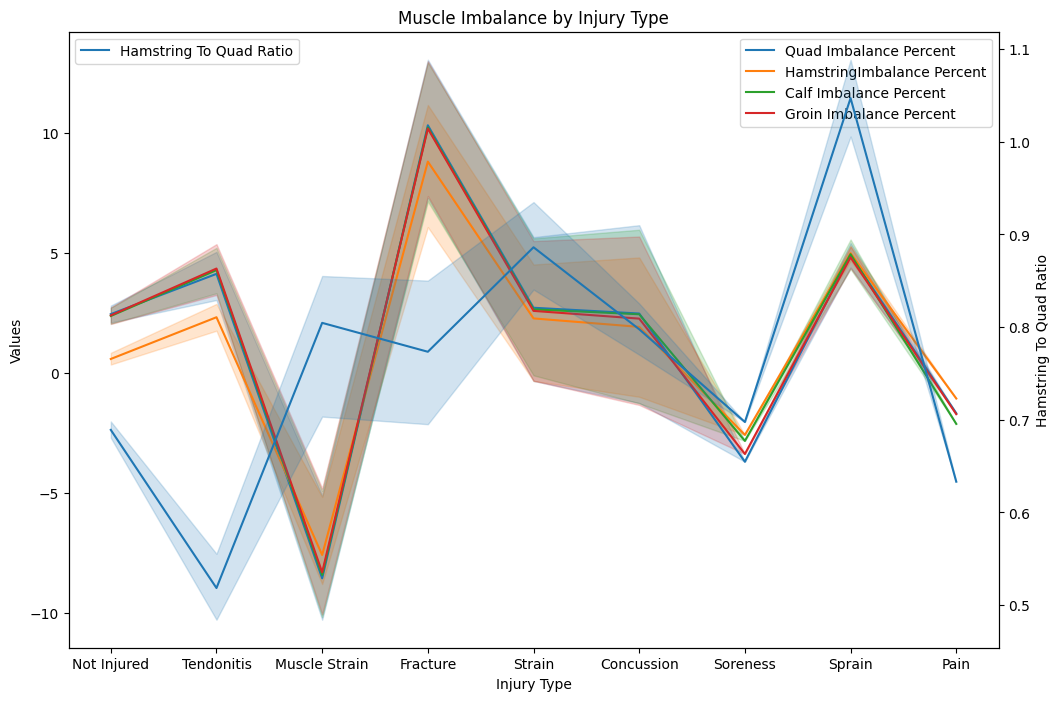

In [34]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

sns.lineplot(x='Injury Type', y='Quad Imbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'Quad Imbalance Percent')
sns.lineplot(x='Injury Type', y='HamstringImbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'HamstringImbalance Percent')
sns.lineplot(x='Injury Type', y='Calf Imbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'Calf Imbalance Percent')
sns.lineplot(x='Injury Type', y='Groin Imbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'Groin Imbalance Percent')
sns.lineplot(x='Injury Type', y='Hamstring To Quad Ratio', data=clean_sorted_obt, ax = ax2, label = 'Hamstring To Quad Ratio')

ax1.set_xlabel('Injury Type')
ax1.set_ylabel('Values')
ax2.set_ylabel('Hamstring To Quad Ratio')
plt.title('Muscle Imbalance by Injury Type')

plt.legend()

plt.show()

/tmp/ipykernel_3012/803376052.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Body Part', y='Hamstring To Quad Ratio', data=clean_sorted_obt, ax = ax2, hue = 'Player.ID', palette = 'pastel', ci = None)


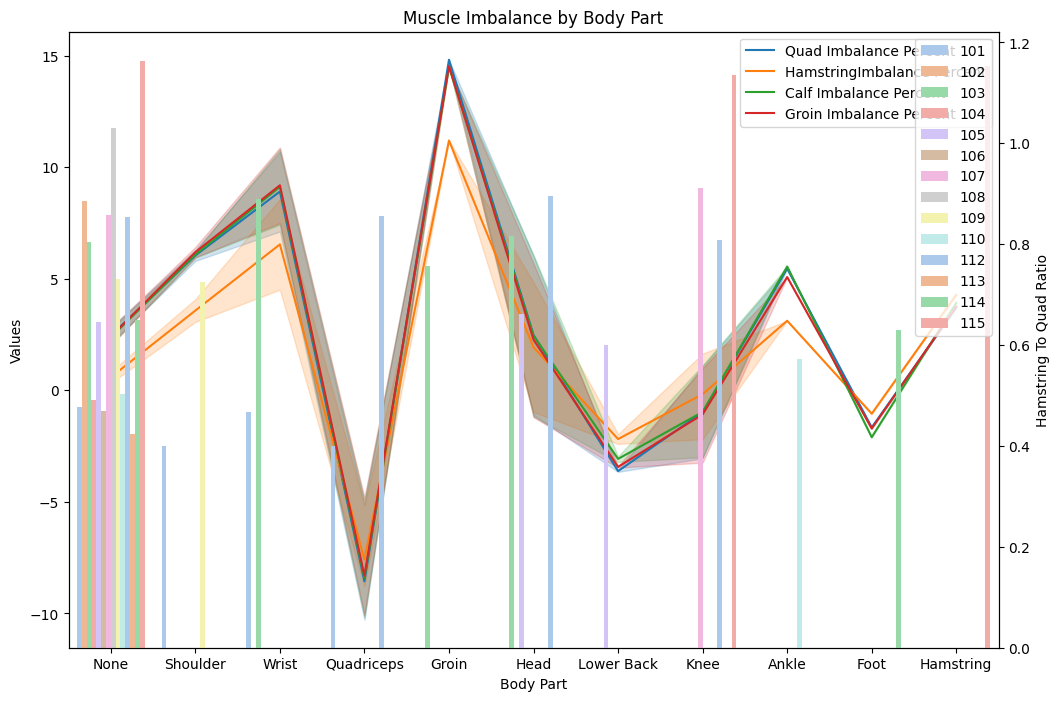

In [169]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

sns.lineplot(x='Body Part', y='Quad Imbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'Quad Imbalance Percent')
sns.lineplot(x='Body Part', y='HamstringImbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'HamstringImbalance Percent')
sns.lineplot(x='Body Part', y='Calf Imbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'Calf Imbalance Percent')
sns.lineplot(x='Body Part', y='Groin Imbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'Groin Imbalance Percent')
sns.barplot(x='Body Part', y='Hamstring To Quad Ratio', data=clean_sorted_obt, ax = ax2, hue = 'Player.ID', palette = 'pastel', ci = None)

ax1.set_xlabel('Body Part')
ax1.set_ylabel('Values')
ax2.set_ylabel('Hamstring To Quad Ratio')
plt.title('Muscle Imbalance by Body Part')

plt.legend()
plt.show()

/tmp/ipykernel_3012/1382982470.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Injury Type', y='Exertions', data=clean_sorted_obt, hue = 'Player.ID', ax = ax1, palette = 'pastel', ci = None)


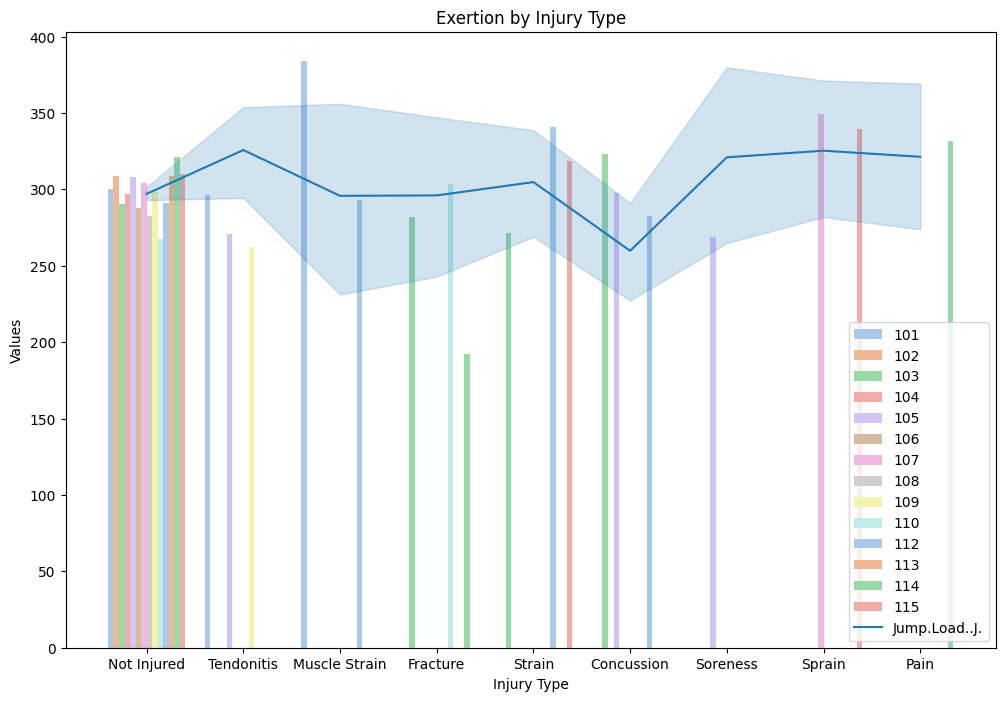

In [167]:
fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x='Injury Type', y='Exertions', data=clean_sorted_obt, hue = 'Player.ID', ax = ax1, palette = 'pastel', ci = None)
sns.lineplot(x='Injury Type', y='Jump.Load..J.', data=clean_sorted_obt, ax = ax1, label = 'Jump.Load..J.')

ax1.set_xlabel('Injury Type')
ax1.set_ylabel('Values')
plt.title('Exertion by Injury Type')

plt.legend()

plt.show()

/tmp/ipykernel_3012/618323314.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


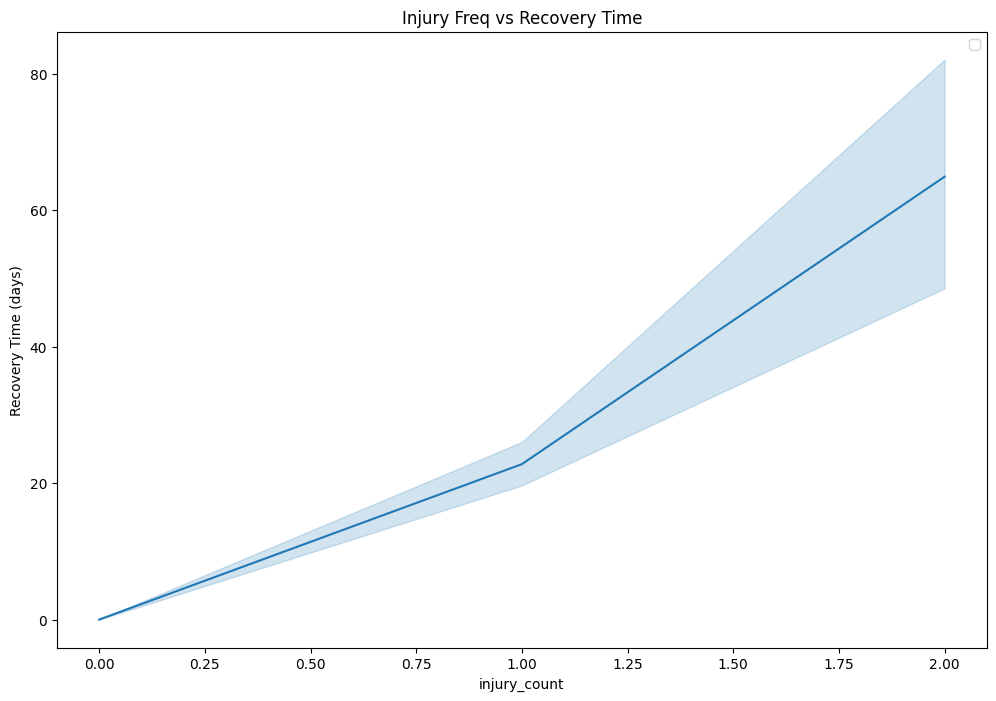

In [45]:
fig, ax1 = plt.subplots(figsize=(12, 8))
#ax2 = ax1.twiny()

sns.lineplot(x='injury_number', y='Recovery Time (days)', data=clean_sorted_obt, ax = ax1)
#sns.lineplot(x='Injury Type', y='Recovery Time (days)', data=clean_sorted_obt, ax = ax1, label = 'Injury Type')

#ax2.set_xlabel('Injury Type')
ax1.set_xlabel('injury_count')
ax1.set_ylabel('Recovery Time (days)')
plt.title('Injury Freq vs Recovery Time')

plt.legend()

plt.show()

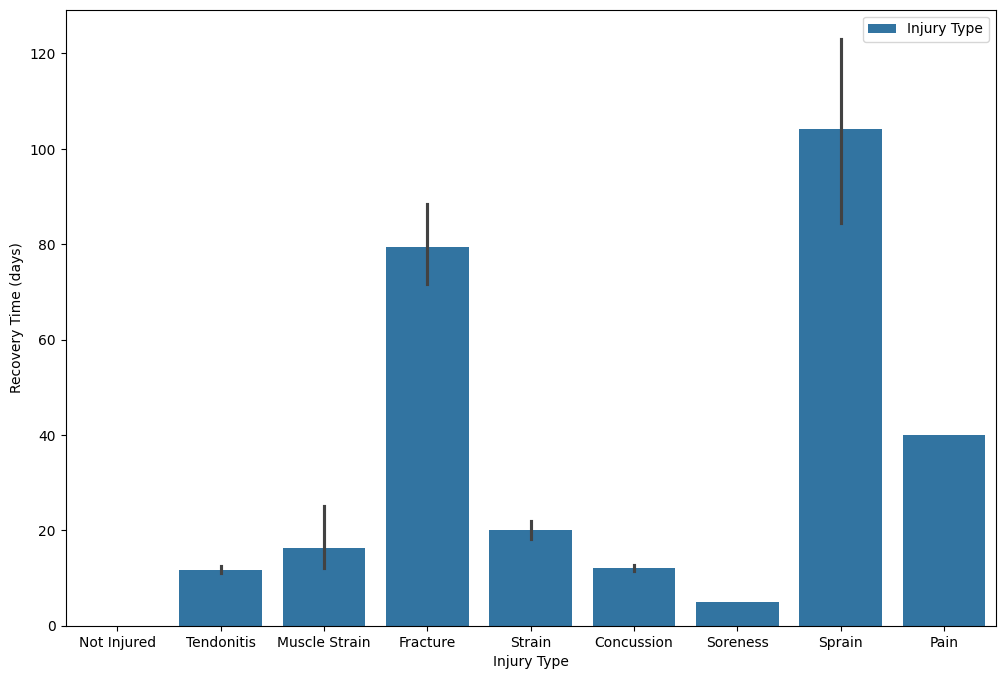

In [44]:
fig, ax1 = plt.subplots(figsize=(12, 8))
sns.barplot(x='Injury Type', y='Recovery Time (days)', data=clean_sorted_obt, ax = ax1, label = 'Injury Type', )

ax1.set_xlabel('Injury Type')

plt.legend()
plt.show()

## Encoding and Scaling

In [46]:
non_cat_data = clean_sorted_obt.select_dtypes(include=['number', 'datetime'])
non_cat_data

,Player.ID,Date Recorded,Hamstring To Quad Ratio,Quad Imbalance Percent,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Month,Year,Session_Date,...,Human.Core.Temperature..max.....F.,TRIMP,Heart.Rate.Recoveries,Jump.Height..max....ft.,Exertions,Disk.Usage....,Injury Date,Recovery Time (days),injury_number,reinjury
930,101,2023-01-01,0.610768,5.481295,3.347801,5.409497,5.616962,1,2023,2023-01-01,...,101.96,114,10,2.37,132,23.12,2026-12-31,0.0,0.0,0
931,101,2023-01-01,0.610768,5.481295,3.347801,5.409497,5.616962,1,2023,2023-01-03,...,102.23,105,4,3.52,194,74.68,2026-12-31,0.0,0.0,0
932,101,2023-01-01,0.610768,5.481295,3.347801,5.409497,5.616962,1,2023,2023-01-04,...,98.16,268,5,2.41,413,52.18,2026-12-31,0.0,0.0,0
933,101,2023-01-01,0.610768,5.481295,3.347801,5.409497,5.616962,1,2023,2023-01-06,...,100.33,245,8,2.12,359,37.75,2026-12-31,0.0,0.0,0
934,101,2023-01-01,0.610768,5.481295,3.347801,5.409497,5.616962,1,2023,2023-01-07,...,101.59,183,5,2.10,405,62.07,2026-12-31,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,115,2023-12-01,1.173804,3.803433,4.464483,3.361765,3.485792,12,2023,2023-12-24,...,102.51,131,7,1.93,296,15.41,2026-12-31,0.0,0.0,0
272,115,2023-12-01,1.173804,3.803433,4.464483,3.361765,3.485792,12,2023,2023-12-25,...,101.75,196,4,2.00,395,24.67,2026-12-31,0.0,0.0,0
273,115,2023-12-01,1.173804,3.803433,4.464483,3.361765,3.485792,12,2023,2023-12-26,...,98.65,276,1,2.34,326,48.27,2026-12-31,0.0,0.0,0
274,115,2023-12-01,1.173804,3.803433,4.464483,3.361765,3.485792,12,2023,2023-12-28,...,101.76,178,6,1.89,444,50.06,2026-12-31,0.0,0.0,0


In [47]:
clean_sorted_obt = clean_sorted_obt.reset_index()

In [48]:
clean_sorted_obt.columns

Index(['index', 'Player.ID', 'Date Recorded', 'Hamstring To Quad Ratio',
       'Quad Imbalance Percent', 'HamstringImbalance Percent',
       'Calf Imbalance Percent', 'Groin Imbalance Percent', 'Month', 'Year',
       'Session_Date', 'Position', 'Distance..mi.', 'Distance...min..mi.',
       'Duration..s.', 'Steps', 'Speed....of.max......', 'Speed..max....mph.',
       'Speed..?ò...mph.', 'Time..s.', 'Accumulated.Acceleration.Load',
       'Anaerobic.Activity..distance...mi.', 'Jump.Load..J.',
       'Heart.Rate..?ò...bpm.', 'Heart.Rate..min....bpm.',
       'Heart.Rate..max....bpm.', 'Human.Core.Temperature..?ò....F.',
       'Human.Core.Temperature..max.....F.', 'TRIMP', 'Heart.Rate.Recoveries',
       'Jump.Height..max....ft.', 'Exertions', 'Disk.Usage....', 'Injury Type',
       'Body Part', 'Injury Date', 'Recovery Time (days)', 'injury_number',
       'reinjury'],
      dtype='object')

In [49]:
ohe = OneHotEncoder(sparse_output=False, drop = 'first')

non_cat_data = clean_sorted_obt.select_dtypes(include=['number', 'datetime'])
non_cat_data_columns = non_cat_data.columns.tolist()
cat_columns = set(clean_sorted_obt.columns) - set(non_cat_data.columns)
cat_data = clean_sorted_obt[list(cat_columns)]

multi_colinear_columns = ['Quad Imbalance Percent', 
    'Injury Type',
       'Body Part', 'Side', 'Injury Date', 'Severity', 'Recovery Time (days)', 'Player.ID', 'Date Recorded', 'Session_Date', 'Month', 'Year' 
       ]
for col in multi_colinear_columns:
    if col in non_cat_data.columns:
        non_cat_data.drop(columns = col, inplace = True)

ohe_cat_data = ohe.fit_transform(cat_data)

ohe_cat_df = pd.DataFrame(ohe_cat_data, columns=list(ohe.get_feature_names_out()))
ohe_injury_data = pd.concat([non_cat_data, ohe_cat_df], axis = 1)
ohe_cat_columns = list(ohe.get_feature_names_out())

col_to_drop = ['level_0', 'index']
for col in col_to_drop :
    if col in ohe_injury_data.columns:
        ohe_injury_data.drop(columns = col, inplace = True)

ohe_injury_data

,Hamstring To Quad Ratio,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Distance..mi.,Distance...min..mi.,Duration..s.,Steps,Speed....of.max......,Speed..max....mph.,...,Injury Type_Fracture,Injury Type_Muscle Strain,Injury Type_Not Injured,Injury Type_Pain,Injury Type_Soreness,Injury Type_Sprain,Injury Type_Strain,Injury Type_Tendonitis,Position_Forward,Position_Guard
0,0.610768,3.347801,5.409497,5.616962,5.27,0.13,6246,6552,73.10,13.41,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.610768,3.347801,5.409497,5.616962,5.79,0.12,3758,6701,56.88,14.78,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.610768,3.347801,5.409497,5.616962,3.94,0.11,4895,10088,57.30,17.84,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.610768,3.347801,5.409497,5.616962,3.11,0.10,5319,6355,66.00,16.64,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.610768,3.347801,5.409497,5.616962,3.79,0.08,4327,5828,95.48,15.90,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2599,1.173804,4.464483,3.361765,3.485792,3.09,0.14,4832,5730,72.69,12.70,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2600,1.173804,4.464483,3.361765,3.485792,2.98,0.06,5762,5950,89.08,19.82,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2601,1.173804,4.464483,3.361765,3.485792,1.99,0.07,6521,5456,78.26,12.02,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2602,1.173804,4.464483,3.361765,3.485792,3.02,0.08,4320,7776,82.90,18.98,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [51]:
data_to_scale = non_cat_data.copy()

In [55]:
data_to_scale.columns

Index(['index', 'Hamstring To Quad Ratio', 'HamstringImbalance Percent',
       'Calf Imbalance Percent', 'Groin Imbalance Percent', 'Distance..mi.',
       'Distance...min..mi.', 'Duration..s.', 'Steps', 'Speed....of.max......',
       'Speed..max....mph.', 'Speed..?ò...mph.', 'Time..s.',
       'Accumulated.Acceleration.Load', 'Anaerobic.Activity..distance...mi.',
       'Jump.Load..J.', 'Heart.Rate..?ò...bpm.', 'Heart.Rate..min....bpm.',
       'Heart.Rate..max....bpm.', 'Human.Core.Temperature..?ò....F.',
       'Human.Core.Temperature..max.....F.', 'TRIMP', 'Heart.Rate.Recoveries',
       'Jump.Height..max....ft.', 'Exertions', 'Disk.Usage....',
       'injury_number', 'reinjury'],
      dtype='object')

In [71]:
scaler = StandardScaler(with_std = True, with_mean= True)

columns = ['index' 'reinjury', 'Injury Type_Not Injured', 'Injury Type_Sprain',
       'Injury Type_Strain', 'Body Part_Hamstring', 'Body Part_Knee',
       'Body Part_None', 'Body Part_Quadriceps']

In [72]:
for col in columns:
    if col in data_to_scale.columns:
        data_to_scale.drop(columns = col, inplace = True)      
unscaled_data = data_to_scale.select_dtypes(include = ['Int64', 'Float64'], exclude = ["datetime"])


if 'index' in unscaled_data.columns:
    unscaled_data.drop(columns = 'index', inplace = True)
if 'reinjury' in unscaled_data.columns:
    unscaled_data.drop(columns = 'reinjury', inplace = True)
columns_to_scale = list(unscaled_data.columns)


if 'index' in ohe_injury_data.columns:
    ohe_injury_data.drop(columns = 'index', inplace = True)
scaled_ohe_injury_data = ohe_injury_data.copy()

scaled_ohe_injury_data[columns_to_scale] = scaler.fit_transform(ohe_injury_data[columns_to_scale])

In [73]:
columns_to_scale

['Hamstring To Quad Ratio',
 'HamstringImbalance Percent',
 'Calf Imbalance Percent',
 'Groin Imbalance Percent',
 'Distance..mi.',
 'Distance...min..mi.',
 'Duration..s.',
 'Steps',
 'Speed....of.max......',
 'Speed..max....mph.',
 'Speed..?ò...mph.',
 'Time..s.',
 'Accumulated.Acceleration.Load',
 'Anaerobic.Activity..distance...mi.',
 'Jump.Load..J.',
 'Heart.Rate..?ò...bpm.',
 'Heart.Rate..min....bpm.',
 'Heart.Rate..max....bpm.',
 'Human.Core.Temperature..?ò....F.',
 'Human.Core.Temperature..max.....F.',
 'TRIMP',
 'Heart.Rate.Recoveries',
 'Jump.Height..max....ft.',
 'Exertions',
 'Disk.Usage....',
 'injury_number']

In [74]:
scaled_ohe_injury_data

,Hamstring To Quad Ratio,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Distance..mi.,Distance...min..mi.,Duration..s.,Steps,Speed....of.max......,Speed..max....mph.,...,Injury Type_Fracture,Injury Type_Muscle Strain,Injury Type_Not Injured,Injury Type_Pain,Injury Type_Soreness,Injury Type_Sprain,Injury Type_Strain,Injury Type_Tendonitis,Position_Forward,Position_Guard
0,-0.386573,0.402822,0.343322,0.362922,1.252648,1.085850,0.849847,-1.035621,-0.206006,-0.546433,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.386573,0.402822,0.343322,0.362922,1.623406,0.723529,-1.651860,-0.956969,-1.440264,-0.051658,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.386573,0.402822,0.343322,0.362922,0.304362,0.361208,-0.508596,0.830908,-1.408305,1.053461,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.386573,0.402822,0.343322,0.362922,-0.287425,-0.001113,-0.082260,-1.139610,-0.746280,0.620081,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.386573,0.402822,0.343322,0.362922,0.197413,-0.725755,-1.079725,-1.417795,1.496996,0.352830,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2599,2.183562,0.573541,0.109896,0.121217,-0.301685,1.448172,-0.571943,-1.469526,-0.237205,-0.802850,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2600,2.183562,0.573541,0.109896,0.121217,-0.380114,-1.450398,0.363180,-1.353396,1.009989,1.768538,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2601,2.183562,0.573541,0.109896,0.121217,-1.085981,-1.088077,1.126362,-1.614161,0.186643,-1.048432,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2602,2.183562,0.573541,0.109896,0.121217,-0.351594,-0.725755,-1.086764,-0.389515,0.539723,1.465172,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [75]:
scaled_ohe_injury_data.columns

Index(['Hamstring To Quad Ratio', 'HamstringImbalance Percent',
       'Calf Imbalance Percent', 'Groin Imbalance Percent', 'Distance..mi.',
       'Distance...min..mi.', 'Duration..s.', 'Steps', 'Speed....of.max......',
       'Speed..max....mph.', 'Speed..?ò...mph.', 'Time..s.',
       'Accumulated.Acceleration.Load', 'Anaerobic.Activity..distance...mi.',
       'Jump.Load..J.', 'Heart.Rate..?ò...bpm.', 'Heart.Rate..min....bpm.',
       'Heart.Rate..max....bpm.', 'Human.Core.Temperature..?ò....F.',
       'Human.Core.Temperature..max.....F.', 'TRIMP', 'Heart.Rate.Recoveries',
       'Jump.Height..max....ft.', 'Exertions', 'Disk.Usage....',
       'injury_number', 'reinjury', 'Body Part_Foot', 'Body Part_Groin',
       'Body Part_Hamstring', 'Body Part_Head', 'Body Part_Knee',
       'Body Part_Lower Back', 'Body Part_None', 'Body Part_Quadriceps',
       'Body Part_Shoulder', 'Body Part_Wrist', 'Injury Type_Fracture',
       'Injury Type_Muscle Strain', 'Injury Type_Not Injured',
   

In [76]:
scaled_ohe_injury_data['reinjury'].value_counts()

reinjury
0    2553
1      51
Name: count, dtype: int64

In [144]:
smote = SMOTE(random_state=42)
log_reg = LogisticRegression(solver = 'lbfgs')

predictors = scaled_ohe_injury_data.drop(columns = ["reinjury", 'Injury Type_Fracture',
       'Injury Type_Muscle Strain', 'Injury Type_Not Injured',
       'Injury Type_Pain', 'Injury Type_Soreness', 'Injury Type_Sprain',
       'Injury Type_Strain', 'Injury Type_Tendonitis', 'Position_Forward',
       'Position_Guard', 'injury_number']) # Dropping target variable and multi-colinear features as well
predictors = predictors.select_dtypes(exclude = ['datetime']) # Removing date time as it should not be needed. 
target = scaled_ohe_injury_data['reinjury']

x_res, y_res = smote.fit_resample(predictors, target)

In [145]:
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, train_size=0.7, random_state = 999)

In [146]:
x_train.shape

(3574, 35)

In [147]:
y_train

554     0
1151    0
1678    0
5010    1
3274    1
       ..
2523    0
225     0
481     0
4965    1
4444    1
Name: reinjury, Length: 3574, dtype: int64

In [148]:
scores = cross_val_score(log_reg, x_train, y_train, cv = 5, scoring = 'f1')
cv_score = np.mean(scores)
cv_score

np.float64(0.9923939475615683)

In [149]:
log_reg_model = log_reg.fit(x_train, y_train)
prediction = log_reg_model.predict(x_test)

accuracy = accuracy_score(y_test, prediction)
report = classification_report(y_test, prediction)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       739
           1       0.99      1.00      0.99       793

    accuracy                           0.99      1532
   macro avg       0.99      0.99      0.99      1532
weighted avg       0.99      0.99      0.99      1532



In [150]:
accuracy

0.9934725848563969

In [151]:
prediction = log_reg_model.predict_proba(x_test)
prediction[:,1]

array([9.93448093e-01, 4.61970173e-05, 9.94939104e-01, ...,
       9.89028409e-01, 2.73453974e-03, 3.66397725e-03])

In [152]:
# Get the coefficients for each feature
coefficients = log_reg.coef_

# Print the coefficients
print("Coefficients:", coefficients)

Coefficients: [[ 1.90732851  1.07277316 -0.91512834 -0.21890003  0.16625637  0.13525853
   0.01521943 -0.15496813  0.16527779  0.14439095  0.23752271 -0.05504954
   0.11268498  0.23547246 -0.01614734  0.09735845  0.19885761  0.11359623
   0.11918649 -0.03578952  0.36405994  0.12052945  0.18607845 -0.12121905
   0.25537225  7.52163286 -0.95740092 -2.80347623 -1.92743441  1.1987849
   5.48431214 -5.41654575 -1.16999709 -0.96214795 -1.54765859]]


In [153]:
prob_df = pd.DataFrame({
    'True Values' : y_test,
    'Probabilities': prediction[:,1]
})

prob_df.head()

,True Values,Probabilities
4472,1,0.993448
2222,0,0.000046
4347,1,0.994939
1274,0,0.003279
4271,1,0.996649


In [154]:
columns = x_train.columns.tolist()
coefficients_with_intercept = coefficients[0].tolist()  

coeff_df = pd.DataFrame({
    'Features': columns,
    'Coefficients': coefficients_with_intercept
})

coeff_df.sort_values('Coefficients')


,Features,Coefficients
31,Body Part_None,-5.416546
27,Body Part_Hamstring,-2.803476
28,Body Part_Head,-1.927434
34,Body Part_Wrist,-1.547659
32,Body Part_Quadriceps,-1.169997
33,Body Part_Shoulder,-0.962148
26,Body Part_Groin,-0.957401
2,Calf Imbalance Percent,-0.915128
3,Groin Imbalance Percent,-0.218900
7,Steps,-0.154968


## Model 2

In [155]:
rfc = RandomForestClassifier(n_estimators = 200, criterion = 'gini')

model2_cv_scores = np.mean(cross_val_score(rfc, x_train, y_train, cv = 3, scoring = 'f1'))
model2_cv_scores

np.float64(0.9997163120567376)

In [156]:
rfc_model = rfc.fit(x_train, y_train)
model2_pred = rfc_model.predict(x_test)

model2_accuracy = accuracy_score(y_test, model2_pred)
model2_accuracy

1.0

In [157]:
print(classification_report(y_test, model2_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       739
           1       1.00      1.00      1.00       793

    accuracy                           1.00      1532
   macro avg       1.00      1.00      1.00      1532
weighted avg       1.00      1.00      1.00      1532



In [158]:
rfc_probabilities = rfc_model.predict_proba(x_test)
rfc_probabilities[:, 1].tolist()

[1.0,
 0.0,
 0.995,
 0.0,
 1.0,
 0.0,
 0.005,
 0.0,
 0.0,
 0.985,
 1.0,
 0.0,
 0.995,
 1.0,
 1.0,
 0.0,
 0.995,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.005,
 0.005,
 1.0,
 1.0,
 1.0,
 1.0,
 0.99,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.005,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.005,
 0.0,
 1.0,
 0.0,
 0.05,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.015,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.995,
 0.005,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.075,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.005,
 1.0,
 0.0,
 1.0,
 0.005,
 0.015,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.005,
 1.0,
 0.0,
 1.0,
 0.0,
 0.005,
 1.0,
 0.0,
 1.0,
 0.005,
 0.0,
 1.0,
 0.0,
 0.99,
 1.0,
 1.0,
 0.995,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.99,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.01,
 0.0,
 0.0,
 1.0,
 0.0,
 0.995,
 0.0,
 1.0,
 1.0,
 1.0,
 0.995,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.005,
 1.0,
 1.0,
 0.0,
 0.0,
 0.075